### Make Parsing and Preprocessing Functions

In [1]:
import os

DATA_DIR = os.path.join("english")

In [2]:
next(os.walk(os.path.join(DATA_DIR, 'Durian')))

('english\\Durian',
 [],
 ['aligned.swc',
  'audio.ogg',
  'audiometa.txt',
  'info.json',
  'wiki.html',
  'wiki.txt',
  'wiki.xml'])

In [4]:
# audio = AudioSegment.from_ogg('english/Durian/audio.ogg')
# print(audio.channels, audio.frame_rate)
# swc = SWC('english/Durian/aligned.swc')
# split_clip(audio, swc)

In [6]:
# clips = load_utterances(None) # 50 minutes to load 100,000 clips
# print(len(clips))
# clips[0]

#### Specifically Audio Manipulation

In [4]:
from pydub import AudioSegment

from data_processing import gen_clip, overlay_noise

clip = gen_clip(AudioSegment.from_file('parsed_files/raw_clips/government_9302.wav'))
noise = AudioSegment.from_file('audio/outside_rural/snipped119_start_240_end_250.wav')
overlay_noise(2.0, clip, noise)

### Count word frequencies to consider which data points we will keep

{'whiskers': [<matplotlib.lines.Line2D at 0x17d81714260>,
 'caps': [<matplotlib.lines.Line2D at 0x17d81717c80>,
 'boxes': [<matplotlib.lines.Line2D at 0x17d81714560>],
 'medians': [<matplotlib.lines.Line2D at 0x17d817176b0>],
 'fliers': [<matplotlib.lines.Line2D at 0x17d81717440>],
 'means': []}

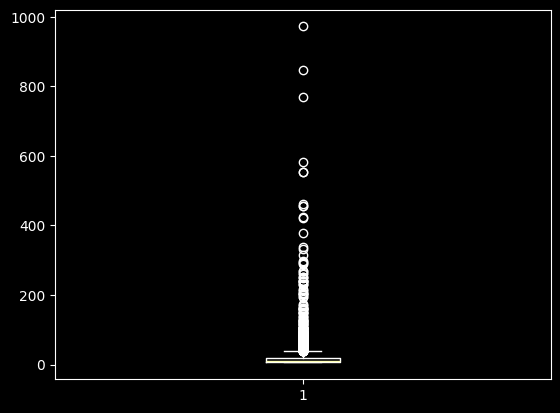

In [10]:
import matplotlib.pyplot as plt

freq_dict = {}
# for pc in clips:
#     freq_dict[pc.word] = freq_dict.get(pc.word, 0) + 1

freqs = list(filter(lambda x: 5 < x < 200000, freq_dict.values()))

plt.boxplot(freqs)

In [14]:
wf = dict(filter(lambda x: 50 < x[1] < 300, freq_dict.items()))
print(f'{len(wf)} words remain after filtering')

with open('vocab.txt', 'w') as f:
    f.write("\n".join(wf.keys()))
    print('wrote vocabulary file')

NameError: name 'freq_dict' is not defined

### Save Audio Files

In [3]:
import os

from data_processing import make_noise_playlist

music_clips = make_noise_playlist(os.path.join('audio', 'music'), 200)
outdoor_clips = make_noise_playlist(os.path.join('audio', 'outside_rural'))
babble_clips = make_noise_playlist(os.path.join('audio', 'babble'))

FileNotFoundError: [WinError 3] The system cannot find the path specified: 'audio\\music'

In [2]:
import time

m_path = os.path.join('parsed_files', 'music')
o_path = os.path.join('parsed_files', 'outdoor')
b_path = os.path.join('parsed_files', 'babble')

os.makedirs(m_path, exist_ok = True)
os.makedirs(o_path, exist_ok = True)
os.makedirs(b_path, exist_ok = True)

In [3]:
from data_processing import load_utterances, load_vocab

vocab = load_vocab()
load_utterances(700, vocab)

Loaded vocabulary vocab.txt with 1 words.
Processing file #50, took 31.222121000289917s
Processing file #100, took 75.3955762386322s
Processing file #150, took 118.96602511405945s
Processing file #200, took 172.90856909751892s
Processing file #250, took 216.94991445541382s
Processing file #300, took 260.6452143192291s
Processing file #350, took 342.6633789539337s
Processing file #400, took 446.7177982330322s
Failed to parse file: Fuck_(film) (Decoding failed. ffmpeg returned error code: 1

Output from ffmpeg/avlib:

ffmpeg version N-93913-g1a74b04737 Copyright (c) 2000-2019 the FFmpeg developers
  built with gcc 8.3.1 (GCC) 20190414
  configuration: --enable-gpl --enable-version3 --enable-sdl2 --enable-fontconfig --enable-gnutls --enable-iconv --enable-libass --enable-libdav1d --enable-libbluray --enable-libfreetype --enable-libmp3lame --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenjpeg --enable-libopus --enable-libshine --enable-libsnappy --enable-libsoxr --enab

In [1]:
from data_processing import load_clips

clips = load_clips()
len(clips)

c:\Users\nwong\Documents\nick-repo\.conda\Lib\site-packages\pycochleagram-0.1-py3.11.egg\pycochleagram\erbfilter.py:8: RuntimeWarning: pycochleagram using non-interactive Agg matplotlib backend
  from pycochleagram import utils


20003

In [2]:
import random
from concurrent.futures import ThreadPoolExecutor

# import numpy as np

from data_processing import overlay_noise_clips

# music is -6dB mean, other noise is -3dB mean. all with 2dB variance
# np.random.seed(123)
# N = len(clips)
N = 6000
# music_snr = np.random.normal(-6, 2, N)
# outdoor_snr = np.random.normal(-3, 2, N)
# babble_snr = np.random.normal(-3, 2, N)

import time

m_path = os.path.join('parsed_files_snrs', 'music')
o_path = os.path.join('parsed_files_snrs', 'outdoor')
b_path = os.path.join('parsed_files_snrs', 'babble')

os.makedirs(m_path, exist_ok = True)
os.makedirs(o_path, exist_ok = True)
os.makedirs(b_path, exist_ok = True)

random.seed(123)
starttime = time.time()
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(
        overlay_noise_clips,
        clip,
        [
            random.choice(music_clips),
            random.choice(outdoor_clips),
            random.choice(babble_clips)
        ],
        [-12.0, -6.0, -3.0, 0.0, 2.0, 6.0, 12.0],
        [m_path, o_path, b_path],
        i, starttime
    ) for i, clip in enumerate(clips[N])]

NameError: name 'os' is not defined

In [ ]:
import random
from concurrent.futures import ThreadPoolExecutor

import numpy as np

from data_processing import overlay_noise_clips

# music is -6dB mean, other noise is -3dB mean. all with 2dB variance
np.random.seed(123)
N = len(clips)

random.seed(123)
starttime = time.time()
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(
        overlay_noise_clips,
        clip,
        [
            random.choice(music_clips),
            random.choice(outdoor_clips),
            random.choice(babble_clips)
        ],
        [music_snr[i], outdoor_snr[i], babble_snr[i]],
        [m_path, o_path, b_path],
        i, starttime
    ) for i, clip in enumerate(clips)]

### Load Data
Load audio files functions, vocabulary, word-to-index dictionary, cochleagrams

In [18]:
from data_processing import load_clips

clips = load_clips()
vocab = load_vocab()

Loaded vocabulary vocab.txt with 237 words.


In [7]:
from data_processing import make_word2ind

word2ind = make_word2ind(clips)
print(f'{len(word2ind)} words from {len(clips)} clips')
word2ind

237 words from 20003 clips


{'union': 0,
 'since': 1,
 'town': 2,
 'public': 3,
 'many': 4,
 'business': 5,
 'season': 6,
 'include': 7,
 'became': 8,
 'family': 9,
 'million': 10,
 'countries': 11,
 'modern': 12,
 'long': 13,
 'played': 14,
 'king': 15,
 'held': 16,
 'fifteen': 17,
 'early': 18,
 'forty': 19,
 'social': 20,
 'part': 21,
 'group': 22,
 'role': 23,
 'eleven': 24,
 'television': 25,
 'century': 26,
 'created': 27,
 'during': 28,
 'english': 29,
 'ninety': 30,
 'seventy': 31,
 'zero': 32,
 'economic': 33,
 'audio': 34,
 'world': 35,
 'largest': 36,
 'produced': 37,
 'made': 38,
 'show': 39,
 'state': 40,
 'church': 41,
 'another': 42,
 'central': 43,
 'between': 44,
 'america': 45,
 'best': 46,
 'then': 47,
 'have': 48,
 'american': 49,
 'born': 50,
 'period': 51,
 'still': 52,
 'their': 53,
 'them': 54,
 'several': 55,
 'science': 56,
 'these': 57,
 'term': 58,
 'than': 59,
 'life': 60,
 'into': 61,
 'only': 62,
 'usually': 63,
 'original': 64,
 'death': 65,
 'released': 66,
 'place': 67,
 'will': 

In [2]:
from data_processing import load_vocab, vocab_word2ind

vocab = load_vocab()
word2ind = vocab_word2ind(vocab)
# load_cochleagrams('parsed_files/babble', word2ind)

Loaded vocabulary vocab.txt with 251 words.


## Train/Test Split

In [3]:
import numpy as np

from data_processing import load_cochleagrams

X = np.zeros([0,256,256])
T = np.zeros([0])

x, t = load_cochleagrams('parsed_files/babble', word2ind, limit=12_000)
X = np.append(X, x, axis=0)
T = np.append(T, t, axis=0)
x, t = load_cochleagrams('parsed_files/music', word2ind, limit=12_000)
X = np.append(X, x, axis=0)
T = np.append(T, t, axis=0)
x, t = load_cochleagrams('parsed_files/outdoor', word2ind, limit=12_000)
X = np.append(X, x, axis=0)
T = np.append(T, t, axis=0)

In [4]:
X.shape, T.shape

((36000, 256, 256), (36000,))

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, T, test_size=0.2,
                                                    random_state=1234)

In [7]:
import os

os.makedirs('model_train/train', exist_ok=True)
os.makedirs('model_train/test', exist_ok=True)

np.save('model_train/train/inputs.npy', X_train)
np.save('model_train/train/targets.npy', y_train)
np.save('model_train/test/inputs.npy', X_test)
np.save('model_train/test/targets.npy', y_test)

#### Load data with given SNR

In [4]:
import numpy as np

from data_processing import load_cochleagrams_with_snr

SNRs = [-12, -6, -3, 0, 2, 6, 12]

for i, snr in enumerate(SNRs):
    X = np.zeros([0,256,256])
    T = np.zeros([0])
    x, t = load_cochleagrams_with_snr('parsed_files_snrs/babble', word2ind, snr, limit=2000)
    np.save(f'model_train/test{snr}dB/inputs_babble.npy', x)
    np.save(f'model_train/test{snr}dB/targets_babble.npy', t)
    X = np.append(X, x, axis=0)
    T = np.append(T, t, axis=0)
    x, t = load_cochleagrams_with_snr('parsed_files_snrs/music', word2ind, snr, limit=2000)
    np.save(f'model_train/test{snr}dB/inputs_music.npy', x)
    np.save(f'model_train/test{snr}dB/targets_music.npy', t)
    X = np.append(X, x, axis=0)
    T = np.append(T, t, axis=0)
    x, t = load_cochleagrams_with_snr('parsed_files_snrs/outdoor', word2ind, snr, limit=2000)
    np.save(f'model_train/test{snr}dB/inputs_outdoor.npy', x)
    np.save(f'model_train/test{snr}dB/targets_outdoor.npy', t)
    X = np.append(X, x, axis=0)
    T = np.append(T, t, axis=0)
    np.save(f'model_train/test{snr}dB/inputs.npy', X)
    np.save(f'model_train/test{snr}dB/targets.npy', T)